# Exploring Role Skill Expression in League

After reading the [Oracle's Elixir blog post](https://oracleselixir.com/2020/02/luck-and-league-measuring-ideal-season-length-in-lol/) I wanted to apply the same approach to roles in League of Legends. I recalculate the results of the blog post, update the half skill half luck breakpoint with the addition of 2020 data, and then apply the approach to roles in a game.

In [211]:
import math
import numpy as np
import pandas as pd
pd.options.display.max_rows = 100
pd.options.display.max_columns = 500
import seaborn as sns

In [212]:
games_2018 = pd.read_csv("../data/2018_LoL_esports_match_data_from_OraclesElixir_20210118.csv")
games_2019 = pd.read_csv("../data/2019_LoL_esports_match_data_from_OraclesElixir_20210118.csv")
games_2020 = pd.read_csv("../data/2020_LoL_esports_match_data_from_OraclesElixir_20210118.csv")

In [213]:
games_2018 = games_2018.replace('NA LCS', 'LCS')

### Validate Function

Recalculating the results from the work of the original [Oracle's Elixir blog post](https://oracleselixir.com/2020/02/luck-and-league-measuring-ideal-season-length-in-lol/) to ensure that I have my math down right.

In [214]:
df = games_2018.append(games_2019, ignore_index=True)

In [215]:
df.shape

(156518, 117)

In [216]:
df = df[df['league'].isin(['LCS', 'LEC'])]
df['datacompleteness'].value_counts()

complete    8292
partial       24
Name: datacompleteness, dtype: int64

In [217]:
df = df[df['datacompleteness'] == 'complete']
df = df[df['playoffs'] == 0]
df.shape

(6624, 117)

In [218]:
df.head(10)

,gameid,datacompleteness,url,league,year,split,playoffs,date,game,patch,playerid,side,position,player,team,champion,ban1,ban2,ban3,ban4,ban5,gamelength,result,kills,deaths,assists,teamkills,teamdeaths,doublekills,triplekills,quadrakills,pentakills,firstblood,firstbloodkill,firstbloodassist,firstbloodvictim,team kpm,ckpm,firstdragon,dragons,opp_dragons,elementaldrakes,opp_elementaldrakes,infernals,mountains,clouds,oceans,dragons (type unknown),elders,opp_elders,firstherald,heralds,opp_heralds,firstbaron,barons,opp_barons,firsttower,towers,opp_towers,firstmidtower,firsttothreetowers,inhibitors,opp_inhibitors,damagetochampions,dpm,damageshare,damagetakenperminute,damagemitigatedperminute,wardsplaced,wpm,wardskilled,wcpm,controlwardsbought,visionscore,vspm,totalgold,earnedgold,earned gpm,earnedgoldshare,goldspent,gspd,total cs,minionkills,monsterkills,monsterkillsownjungle,monsterkillsenemyjungle,cspm,goldat10,xpat10,csat10,opp_goldat10,opp_xpat10,opp_csat10,golddiffat10,xpdiffat10,csdiffat10,killsat10,assistsat10,deathsat10,opp_killsat10,opp_assistsat10,opp_deathsat10,goldat15,xpat15,csat15,opp_goldat15,opp_xpat15,opp_csat15,golddiffat15,xpdiffat15,csdiffat15,killsat15,assistsat15,deathsat15,opp_killsat15,opp_assistsat15,opp_deathsat15
1692,TRLH1/1002440062,complete,http://matchhistory.na.leagueoflegends.com/en/...,LCS,2018,Spring,0,2018-01-20 20:50:09,1,8.01,1,Blue,top,Impact,Team Liquid,Gangplank,Ornn,Zoe,Azir,Thresh,Kha'Zix,1687,1,3,0,6,11,1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.3912,0.4268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,16858,599.5732,0.367870,386.8880,319.9881,14,0.4979,2,0.0711,2,24.0,0.8536,13474,9757,347.0184,0.239742,12133.0,NaN,254.0,248.0,6,1,4,9.0338,3650.0,4637.0,77.0,3119.0,4254.0,78.0,531.0,383.0,-1.0,0.0,1.0,0.0,0.0,0.0,1.0,5824.0,7885.0,130.0,5087.0,7378.0,140.0,737.0,507.0,-10.0,0.0,3.0,0.0,0.0,0.0,1.0
1693,TRLH1/1002440062,complete,http://matchhistory.na.leagueoflegends.com/en/...,LCS,2018,Spring,0,2018-01-20 20:50:09,1,8.01,2,Blue,jng,Xmithie,Team Liquid,Gragas,Ornn,Zoe,Azir,Thresh,Kha'Zix,1687,1,0,0,9,11,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3912,0.4268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,4355,154.8903,0.095033,778.6841,808.5951,22,0.7825,9,0.3201,9,56.0,1.9917,9998,6281,223.3906,0.154331,8325.0,NaN,162.0,26.0,136,97,16,5.7617,2801.0,3194.0,50.0,3190.0,3707.0,70.0,-389.0,-513.0,-20.0,0.0,0.0,0.0,0.0,0.0,0.0,4641.0,5945.0,88.0,4643.0,5427.0,101.0,-2.0,518.0,-13.0,0.0,3.0,0.0,0.0,0.0,1.0
1694,TRLH1/1002440062,complete,http://matchhistory.na.leagueoflegends.com/en/...,LCS,2018,Spring,0,2018-01-20 20:50:09,1,8.01,3,Blue,mid,Pobelter,Team Liquid,Malzahar,Ornn,Zoe,Azir,Thresh,Kha'Zix,1687,1,2,1,7,11,1,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.3912,0.4268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,10390,369.5317,0.226727,251.2033,219.6562,17,0.6046,5,0.1778,6,34.0,1.2092,12316,8599,305.8328,0.211288,10950.0,NaN,278.0,260.0,18,13,4,9.8874,3818.0,4866.0,95.0,3620.0,5005.0,103.0,198.0,-139.0,-8.0,1.0,0.0,0.0,0.0,0.0,0.0,5897.0,7708.0,146.0,5540.0,8006.0,162.0,357.0,-298.0,-16.0,2.0,0.0,0.0,0.0,0.0,0.0
1695,TRLH1/1002440062,complete,http://matchhistory.na.leagueoflegends.com/en/...,LCS,2018,Spring,0,2018-01-20 20:50:09,1,8.01,4,Blue,bot,Doublelift,Team Liquid,Tristana,Ornn,Zoe,Azir,Thresh,Kha'Zix,1687,1,5,0,5,11,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3912,0.4268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,11534,410.2193,0.251691,168.4410,361.2448,14,0.4979,11,0.3912,3,40.0,1.4226,14046,10329,367.3622,0.253797,12375.0,NaN,289.0,253.0,36,13,8,10.2786,3510.0,3360.0,94.0,3563.0,3173.0,97.0,-53.0,187.0,-3.0,0.0,0.0,0.0,0.0,0.0,0.0,6213.0,5507.0,142.0,5395.0,5280.0,155.0,818.0,227.0,-13.0,2.0,1.0,0.0,0.0,0.0,1.0
1696,TRLH1/1002440062,complete,http://matchhistory.na.leagueoflegends.com/en/...,LCS,2018,

In [219]:
validation_df = df.groupby(['team', 'year', 'split']).mean().reset_index()

In [220]:
validation_df.shape

(60, 103)

In [221]:
#validation_df.head()

In [222]:
win_percentage_standard_deviation = validation_df['result'].std()
print(win_percentage_standard_deviation)

0.17078795942724667


In [223]:
games_in_split = 18
random_standard_deviation = math.sqrt(.25 / games_in_split)
print(random_standard_deviation)

0.11785113019775792


In [224]:
#var_observed = var_true + var_random
var_observed = win_percentage_standard_deviation ** 2
var_random = random_standard_deviation ** 2
var_true = var_observed - var_random
print("var_observed: ", var_observed)
print("var_random: ", var_random)
print("var_true: ", var_true)

var_observed:  0.029168527085322856
var_random:  0.013888888888888888
var_true:  0.015279638196433968


In [225]:
games_breakpoint = .25 / (var_true)
print(games_breakpoint)

16.361643959498082


In [226]:
def get_games_breakpoint(win_pct_column, num_games_season):
    win_percentage_standard_deviation = win_pct_column.std()
    random_standard_deviation = math.sqrt(.25 / num_games_season)
    var_observed = win_percentage_standard_deviation ** 2
    var_random = random_standard_deviation ** 2
    var_true = var_observed - var_random
    games_breakpoint = .25 / (var_true)
    return games_breakpoint

In [227]:
breakpoint = get_games_breakpoint(validation_df['result'], 18)
print(breakpoint)

16.361643959498082


### Run Function with 2020 Data

In [228]:
games = games_2018.append(games_2019, ignore_index=True)
games = games.append(games_2020, ignore_index=True)
games.shape

(243321, 117)

In [229]:
df = games[games['league'].isin(['LCS', 'LEC'])]
df['datacompleteness'].value_counts()

complete    14280
partial        96
Name: datacompleteness, dtype: int64

In [230]:
df = df[df['datacompleteness'] == 'complete']
df = df[df['playoffs'] == 0]
df.shape

(10992, 117)

In [231]:
#df.head()

In [232]:
season_length_breakpoint_df = df.groupby(['team', 'year', 'split']).mean().reset_index()
#season_length_breakpoint_df.head(10)

In [233]:
breakpoint = get_games_breakpoint(season_length_breakpoint_df['result'], 18)
print(breakpoint)

14.365126087736414


### Analyze Roles

In [234]:
df['killdiffat10'] = df['killsat10'] - df['opp_killsat10']
df['killdiffat15'] = df['killsat15'] - df['opp_killsat15']
#reversed because the simple win will interpret this as a loss without the adjustment
df['inv_deathdiffat10'] = df['opp_deathsat10'] - df['deathsat10']
df['inv_deathdiffat15'] = df['opp_deathsat15'] - df['deathsat15']
df['assistdiffat10'] = df['assistsat10'] - df['opp_assistsat10']
df['assistdiffat15'] = df['assistsat15'] - df['opp_assistsat15']

df.head(10)

,gameid,datacompleteness,url,league,year,split,playoffs,date,game,patch,playerid,side,position,player,team,champion,ban1,ban2,ban3,ban4,ban5,gamelength,result,kills,deaths,assists,teamkills,teamdeaths,doublekills,triplekills,quadrakills,pentakills,firstblood,firstbloodkill,firstbloodassist,firstbloodvictim,team kpm,ckpm,firstdragon,dragons,opp_dragons,elementaldrakes,opp_elementaldrakes,infernals,mountains,clouds,oceans,dragons (type unknown),elders,opp_elders,firstherald,heralds,opp_heralds,firstbaron,barons,opp_barons,firsttower,towers,opp_towers,firstmidtower,firsttothreetowers,inhibitors,opp_inhibitors,damagetochampions,dpm,damageshare,damagetakenperminute,damagemitigatedperminute,wardsplaced,wpm,wardskilled,wcpm,controlwardsbought,visionscore,vspm,totalgold,earnedgold,earned gpm,earnedgoldshare,goldspent,gspd,total cs,minionkills,monsterkills,monsterkillsownjungle,monsterkillsenemyjungle,cspm,goldat10,xpat10,csat10,opp_goldat10,opp_xpat10,opp_csat10,golddiffat10,xpdiffat10,csdiffat10,killsat10,assistsat10,deathsat10,opp_killsat10,opp_assistsat10,opp_deathsat10,goldat15,xpat15,csat15,opp_goldat15,opp_xpat15,opp_csat15,golddiffat15,xpdiffat15,csdiffat15,killsat15,assistsat15,deathsat15,opp_killsat15,opp_assistsat15,opp_deathsat15,killdiffat10,killdiffat15,inv_deathdiffat10,inv_deathdiffat15,assistdiffat10,assistdiffat15
1692,TRLH1/1002440062,complete,http://matchhistory.na.leagueoflegends.com/en/...,LCS,2018,Spring,0,2018-01-20 20:50:09,1,8.01,1,Blue,top,Impact,Team Liquid,Gangplank,Ornn,Zoe,Azir,Thresh,Kha'Zix,1687,1,3,0,6,11,1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.3912,0.4268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,16858,599.5732,0.367870,386.8880,319.9881,14,0.4979,2,0.0711,2,24.0,0.8536,13474,9757,347.0184,0.239742,12133.0,NaN,254.0,248.0,6,1,4,9.0338,3650.0,4637.0,77.0,3119.0,4254.0,78.0,531.0,383.0,-1.0,0.0,1.0,0.0,0.0,0.0,1.0,5824.0,7885.0,130.0,5087.0,7378.0,140.0,737.0,507.0,-10.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,3.0
1693,TRLH1/1002440062,complete,http://matchhistory.na.leagueoflegends.com/en/...,LCS,2018,Spring,0,2018-01-20 20:50:09,1,8.01,2,Blue,jng,Xmithie,Team Liquid,Gragas,Ornn,Zoe,Azir,Thresh,Kha'Zix,1687,1,0,0,9,11,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3912,0.4268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,4355,154.8903,0.095033,778.6841,808.5951,22,0.7825,9,0.3201,9,56.0,1.9917,9998,6281,223.3906,0.154331,8325.0,NaN,162.0,26.0,136,97,16,5.7617,2801.0,3194.0,50.0,3190.0,3707.0,70.0,-389.0,-513.0,-20.0,0.0,0.0,0.0,0.0,0.0,0.0,4641.0,5945.0,88.0,4643.0,5427.0,101.0,-2.0,518.0,-13.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,3.0
1694,TRLH1/1002440062,complete,http://matchhistory.na.leagueoflegends.com/en/...,LCS,2018,Spring,0,2018-01-20 20:50:09,1,8.01,3,Blue,mid,Pobelter,Team Liquid,Malzahar,Ornn,Zoe,Azir,Thresh,Kha'Zix,1687,1,2,1,7,11,1,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.3912,0.4268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,10390,369.5317,0.226727,251.2033,219.6562,17,0.6046,5,0.1778,6,34.0,1.2092,12316,8599,305.8328,0.211288,10950.0,NaN,278.0,260.0,18,13,4,9.8874,3818.0,4866.0,95.0,3620.0,5005.0,103.0,198.0,-139.0,-8.0,1.0,0.0,0.0,0.0,0.0,0.0,5897.0,7708.0,146.0,5540.0,8006.0,162.0,357.0,-298.0,-16.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0
1695,TRLH1/1002440062,complete,http://matchhistory.na.leagueoflegends.com/en/...,LCS,2018,Spring,0,2018-01-20 20:50:09,1,8.01,4,Blue,bot,Doublelift,Team Liquid,Tristana,Ornn,Zoe,Azir,Thresh,Kha'Zix,1687,1,5,0,5,11,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3912,0.4268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,11534,410.2193,0.251691,168.4410,361.2448,14,0.4979,11,0.3912,3,40.0,1.4226,14046,10329,367.3622,0.253797,12375.0,NaN,289.0,253.0,36,13,8,10.2786,3510.0,3360.0,94.0,3563.0,3173.0,97.0,-53.0,187.0,-3.0,0.0,0.0,0.0,0.0,0.0,0.0,6213.0,5

In [235]:
position_labels = ['top', 'jng', 'mid', 'bot', 'sup']
positional_metrics = ['golddiffat10', 'xpdiffat10', 'csdiffat10', 'golddiffat15', 'xpdiffat15', 'csdiffat15', \
                     'killdiffat10', 'killdiffat15', 'inv_deathdiffat10', 'inv_deathdiffat15', 'assistdiffat10', \
                     'assistdiffat15']

In [236]:
def simple_positional_win(metric):
    if metric > 0:
        return 1
    else:
        return 0

In [237]:
for position in position_labels:
    for selected_metric in positional_metrics:
        roles_df = df[df['position'] == position]
        roles_df['positional_win'] = df[selected_metric].apply(lambda x: simple_positional_win(x))
        role_breakpoint_df = roles_df.groupby(['team', 'year', 'split']).mean().reset_index()
        breakpoint = get_games_breakpoint(role_breakpoint_df['positional_win'], 18)
        print(position, '-', selected_metric, ':', str(round(breakpoint, 2)))

top - golddiffat10 : 33.29
top - xpdiffat10 : 45.81
top - csdiffat10 : 20.0


/home/paulperrone/miniconda3/envs/lit-pipeline/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


top - golddiffat15 : 29.35
top - xpdiffat15 : 40.57
top - csdiffat15 : 19.03
top - killdiffat10 : -48.71
top - killdiffat15 : -83.37
top - inv_deathdiffat10 : -87.58
top - inv_deathdiffat15 : 886.76
top - assistdiffat10 : -366.11
top - assistdiffat15 : 71.36
jng - golddiffat10 : 83.63
jng - xpdiffat10 : 36.94
jng - csdiffat10 : 66.5
jng - golddiffat15 : 29.8
jng - xpdiffat15 : 24.52
jng - csdiffat15 : 22.82
jng - killdiffat10 : -260.52
jng - killdiffat15 : -2639.16
jng - inv_deathdiffat10 : -38.83
jng - inv_deathdiffat15 : -848.98
jng - assistdiffat10 : -96.49
jng - assistdiffat15 : 211.51
mid - golddiffat10 : 32.85
mid - xpdiffat10 : 33.94
mid - csdiffat10 : 17.29
mid - golddiffat15 : 23.27
mid - xpdiffat15 : 23.17
mid - csdiffat15 : 15.43
mid - killdiffat10 : -64.33
mid - killdiffat15 : 316.19
mid - inv_deathdiffat10 : -51.78
mid - inv_deathdiffat15 : 76.72
mid - assistdiffat10 : -87.42
mid - assistdiffat15 : 71.44
bot - golddiffat10 : 32.81
bot - xpdiffat10 : 98.98
bot - csdiffat10 

Simple results suggest that different metrics are more expressive of skill in each position.
* Top - CS
* Jng - XP@10, CS@15
* Mid - CS
* Bot - CS
* Sup - XP

In [238]:
print(df['csdiffat10'].std())
print(df['csdiffat15'].std())
print(df['xpdiffat10'].std())
print(df['xpdiffat15'].std())
print(df['golddiffat10'].std())
print(df['golddiffat15'].std())
#print(np.quantile(test['xpdiffat10'], .25))

16.577139829197016
24.3569727912899
555.4981295727965
994.9629521419477
655.1817449498088
1302.1963845335601


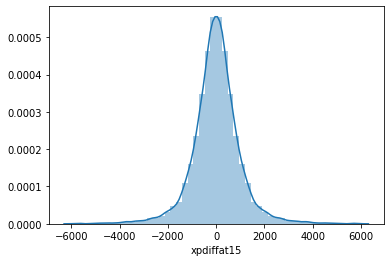

In [239]:
ax = sns.distplot(df['xpdiffat15'])

In [240]:
position_to_10m_metrics = {
    'top': 'csdiffat10',
    'jng': 'xpdiffat10',
    'mid': 'csdiffat10',
    'bot': 'csdiffat10',
    'sup': 'xpdiffat10',
}

position_to_15m_metrics = {
    'top': 'csdiffat15',
    'jng': 'csdiffat15',
    'mid': 'csdiffat15',
    'bot': 'csdiffat15',
    'sup': 'xpdiffat15',
}

In [241]:
for key, value in position_to_10m_metrics.items():
    roles_df = df[df['position'] == key]
    roles_df['positional_win'] = df[value].apply(lambda x: simple_positional_win(x))
    role_breakpoint_df = roles_df.groupby(['team', 'year', 'split']).mean().reset_index()
    breakpoint = get_games_breakpoint(role_breakpoint_df['positional_win'], 18)
    print(key, '-', value, ':', str(round(breakpoint, 2)))

top - csdiffat10 : 20.0
jng - xpdiffat10 : 36.94
mid - csdiffat10 : 17.29
bot - csdiffat10 : 28.9
sup - xpdiffat10 : 69.43


/home/paulperrone/miniconda3/envs/lit-pipeline/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [242]:
for key, value in position_to_15m_metrics.items():
    roles_df = df[df['position'] == key]
    roles_df['positional_win'] = df[value].apply(lambda x: simple_positional_win(x))
    role_breakpoint_df = roles_df.groupby(['team', 'year', 'split']).mean().reset_index()
    breakpoint = get_games_breakpoint(role_breakpoint_df['positional_win'], 18)
    print(key, '-', value, ':', str(round(breakpoint, 2)))

top - csdiffat15 : 19.03
jng - csdiffat15 : 22.82
mid - csdiffat15 : 15.43
bot - csdiffat15 : 21.2
sup - xpdiffat15 : 59.47


/home/paulperrone/miniconda3/envs/lit-pipeline/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Get Player Opponent

In [243]:
df = df[df['playerid'] <= 10]

#df.head()

### Lambda Apply Version
def get_opponent(df, gameid, player, position):
    opponent = df.query(f'(gameid == "{gameid}") and (position == "{position}") and (player != "{player}")')
    opponent = opponent['player'].iloc[0]
    return opponent

df['opponent'] = df.apply(lambda row: get_opponent(df, row['gameid'], row['player'], row['position']),axis=1)

#df.head()


### Lambda Apply w Opp as Key
def get_opponent(df, gameid, golddiffat15):
    opponent = df.query(f'(gameid == "{gameid}") and (golddiffat15 == "{-golddiffat15}")')
    opponent = opponent['player'].iloc[0]
    return opponent

df['opponent'] = df.apply(lambda row: get_opponent(df, row['gameid'], row['golddiffat15']),axis=1)

#df.head()

In [246]:
df.head()

,gameid,datacompleteness,url,league,year,split,playoffs,date,game,patch,playerid,side,position,player,team,champion,ban1,ban2,ban3,ban4,ban5,gamelength,result,kills,deaths,assists,teamkills,teamdeaths,doublekills,triplekills,quadrakills,pentakills,firstblood,firstbloodkill,firstbloodassist,firstbloodvictim,team kpm,ckpm,firstdragon,dragons,opp_dragons,elementaldrakes,opp_elementaldrakes,infernals,mountains,clouds,oceans,dragons (type unknown),elders,opp_elders,firstherald,heralds,opp_heralds,firstbaron,barons,opp_barons,firsttower,towers,opp_towers,firstmidtower,firsttothreetowers,inhibitors,opp_inhibitors,damagetochampions,dpm,damageshare,damagetakenperminute,damagemitigatedperminute,wardsplaced,wpm,wardskilled,wcpm,controlwardsbought,visionscore,vspm,totalgold,earnedgold,earned gpm,earnedgoldshare,goldspent,gspd,total cs,minionkills,monsterkills,monsterkillsownjungle,monsterkillsenemyjungle,cspm,goldat10,xpat10,csat10,opp_goldat10,opp_xpat10,opp_csat10,golddiffat10,xpdiffat10,csdiffat10,killsat10,assistsat10,deathsat10,opp_killsat10,opp_assistsat10,opp_deathsat10,goldat15,xpat15,csat15,opp_goldat15,opp_xpat15,opp_csat15,golddiffat15,xpdiffat15,csdiffat15,killsat15,assistsat15,deathsat15,opp_killsat15,opp_assistsat15,opp_deathsat15,killdiffat10,killdiffat15,inv_deathdiffat10,inv_deathdiffat15,assistdiffat10,assistdiffat15,opponent
1692,TRLH1/1002440062,complete,http://matchhistory.na.leagueoflegends.com/en/...,LCS,2018,Spring,0,2018-01-20 20:50:09,1,8.01,1,Blue,top,Impact,Team Liquid,Gangplank,Ornn,Zoe,Azir,Thresh,Kha'Zix,1687,1,3,0,6,11,1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.3912,0.4268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,16858,599.5732,0.367870,386.8880,319.9881,14,0.4979,2,0.0711,2,24.0,0.8536,13474,9757,347.0184,0.239742,12133.0,NaN,254.0,248.0,6,1,4,9.0338,3650.0,4637.0,77.0,3119.0,4254.0,78.0,531.0,383.0,-1.0,0.0,1.0,0.0,0.0,0.0,1.0,5824.0,7885.0,130.0,5087.0,7378.0,140.0,737.0,507.0,-10.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,3.0,Hauntzer
1693,TRLH1/1002440062,complete,http://matchhistory.na.leagueoflegends.com/en/...,LCS,2018,Spring,0,2018-01-20 20:50:09,1,8.01,2,Blue,jng,Xmithie,Team Liquid,Gragas,Ornn,Zoe,Azir,Thresh,Kha'Zix,1687,1,0,0,9,11,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3912,0.4268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,4355,154.8903,0.095033,778.6841,808.5951,22,0.7825,9,0.3201,9,56.0,1.9917,9998,6281,223.3906,0.154331,8325.0,NaN,162.0,26.0,136,97,16,5.7617,2801.0,3194.0,50.0,3190.0,3707.0,70.0,-389.0,-513.0,-20.0,0.0,0.0,0.0,0.0,0.0,0.0,4641.0,5945.0,88.0,4643.0,5427.0,101.0,-2.0,518.0,-13.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,3.0,MikeYeung
1694,TRLH1/1002440062,complete,http://matchhistory.na.leagueoflegends.com/en/...,LCS,2018,Spring,0,2018-01-20 20:50:09,1,8.01,3,Blue,mid,Pobelter,Team Liquid,Malzahar,Ornn,Zoe,Azir,Thresh,Kha'Zix,1687,1,2,1,7,11,1,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.3912,0.4268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,10390,369.5317,0.226727,251.2033,219.6562,17,0.6046,5,0.1778,6,34.0,1.2092,12316,8599,305.8328,0.211288,10950.0,NaN,278.0,260.0,18,13,4,9.8874,3818.0,4866.0,95.0,3620.0,5005.0,103.0,198.0,-139.0,-8.0,1.0,0.0,0.0,0.0,0.0,0.0,5897.0,7708.0,146.0,5540.0,8006.0,162.0,357.0,-298.0,-16.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,Bjergsen
1695,TRLH1/1002440062,complete,http://matchhistory.na.leagueoflegends.com/en/...,LCS,2018,Spring,0,2018-01-20 20:50:09,1,8.01,4,Blue,bot,Doublelift,Team Liquid,Tristana,Ornn,Zoe,Azir,Thresh,Kha'Zix,1687,1,5,0,5,11,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3912,0.4268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,11534,410.2193,0.251691,168.4410,361.2448,14,0.4979,11,0.3912,3,40.0,1.4226,14046,10329,367.3622,0.253797,12375.0,NaN,289.0,253.0,36,13,8,10.2786,3510.0,3360.0,94.0,3563.0,3173.0,97.0,-53.0,187.0,

In [247]:
#df.to_csv('./test.csv')